# Solving the cart pole problem based on the images of the environment (using deep Q-neural networks)

In [1]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T 

/home/lizarzgu/.local/share/virtualenvs/PoleProjetS8-jl3j6xPV/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:228: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  interpolation: int = Image.BILINEAR,
/home/lizarzgu/.local/share/virtualenvs/PoleProjetS8-jl3j6xPV/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:295: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  interpolation: int = Image.NEAREST,
/home/lizarzgu/.local/share/virtualenvs/PoleProjetS8-jl3j6xPV/lib/python3.8/site-packages/torchvision/transforms/functional_pil.py:328: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  interpolation: int = Image.BICUBIC,


In [2]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display  

## Setting up the deep Q-neural network 

The neural network used is a Multilayer Perceptron with $40*90*3 = 10800$ neurons as its entry (the flattened cropped image), 24 neuros at the first hidden layer, 32 neuros at the second hidden layer and 2 neurons at its output (left and right - two possible actions to be taken).

In [3]:
class DQN(nn.Module):
    
    def __init__(self, img_height, img_width):
        super().__init__()

        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Creating a tuple type for storing experiences

In [4]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [5]:
e = Experience(2, 3, 1, 4)
e

Experience(state=2, action=3, next_state=1, reward=4)

## Creating a ReplayMemory for storing and managing the collected experiences

In [6]:
class ReplayMemory():
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Creating class for managing the Exploration - Exploitation bias (by using the Epsilon Greedy strategy)

In [7]:
class EpsilonGreedyStrategy():
    
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end)*math.exp(-current_step*self.decay)

## Creating class to implement the agent that decides which action is to be taken given the current state

In [8]:
class Agent():
    
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit  

## Creating class that manages the cart pole environment (applies action chosen by Agent, collects and processes images)

In [9]:
class CartPoleEnvManager():
    
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    # Resets environment if episodes reaches its end
    def reset(self):
        self.env.reset()
        self.current_screen = None

    # Closes environment
    def close(self):
        self.env.close()

    # Shows the image of the cart pole environment
    def render(self, mode='human'):
        return self.env.render(mode)
    
    # Gets number of possible actions to be taken
    def num_actions_available(self):
        return self.env.action_space.n
    
    # Applies action chosen by the Agent
    def take_action(self, action):        
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    
    # Checks if the episode is at its first iteration
    def just_starting(self):
        return self.current_screen is None
    
    # Gets the difference between images of current and previous states (entry of the deep Q-neural network)
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    # Gets height (in pixels) of the screen returned by the environmnent
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    # Gets width (in pixels) of the screen returned by the environmnent
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    # Gets processed image (after cropping and rescaling)
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    # Crops the raw image returned by the environment
    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    # Preprocess the cropped image (Rescales it)
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

## Example of non-processed image

/home/lizarzgu/.local/share/virtualenvs/PoleProjetS8-jl3j6xPV/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


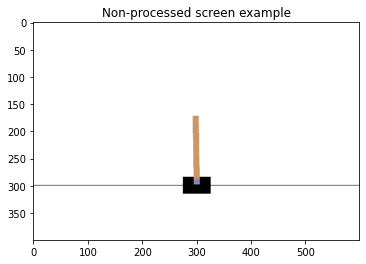

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

## Example of processed image (after cropping and rescaling the raw image)

In [11]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

## Starting screen (all black)

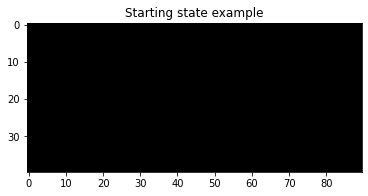

In [12]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

## Example of difference between current and previous states (entry of deep Q-neural network)

In [13]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()
screen = screen.squeeze(0).permute(1, 2, 0).cpu()
screen /= torch.max(screen)

plt.figure()
plt.imshow(screen)
plt.title('Non starting state example')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


## Ending screen (all black)

In [14]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

## Functions used to plot the moving average of the rewards obtained by the reinforcement learning algorithm

In [15]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

In [16]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

## Function used to extract information from the experience special tuple type

In [17]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

## Class used for the training of the deep Q-neural network

In [18]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## Setting up parameters for the training of the deep Q-neural network

In [19]:
batch_size = 256 # size of the memories batch to train the policy net
gamma = 0.999 # used to calculate expected total reward

# Epsilon Greedy strategy parameters
eps_start = 1
eps_end = 0.01
eps_decay = 0.001

target_update = 10 # update target net after 10 training epochs of policy net
memory_size = 100000 # maximum replay memory size
lr = 0.001 # learning rate for the training of policy net
num_episodes = 150 # number of episodes considered during policy net's training
mov_avg_per = 50 # moving average period

## Setting up cart pole manager and Epsilon Greedy strategy

In [20]:
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

## Setting up agent and replay memory

In [21]:
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

## Setting up deep Q-neural networks

Policy net is the network used to determine the actions taken by the agent and the target net is the network used to avoid instabilities during policy net's training.

In [22]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

In [23]:
# Loading the targt net with policy net's synaptic weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [24]:
# Optimizer for the policy net's training
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

## Running reinforcement learning algorithm

The longer the duration of the episode, the better the performance.

In [25]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net) # selecting action to be taken
        reward = em.take_action(action) # taking action and collecting respective reward
        next_state = em.get_state() # getting current state
        memory.push(Experience(state, action, next_state, reward)) # storing experience at the replay memory
        state = next_state # updating current state variable
        
        if memory.can_provide_sample(batch_size): # if replay memory has, at least, batch_size (256) memories
            experiences = memory.sample(batch_size) # random samples batch_size (256) memories from replay memory
            states, actions, rewards, next_states = extract_tensors(experiences) # extract information from obtained experiences tuples

            # calculating current Q-values and target Q-values
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            # training policy net based on mean squared loss
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done: # if episode is finished
            episode_durations.append(timestep)
            plot(episode_durations, mov_avg_per)
            break
            
    # updating target net
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
        
em.close()

Episode 150 
 50 episode moving avg: 14.84


## Playing one episode of the cart pole environment (after training)

em.reset()
state = em.get_state()

for timestep in count():

    with torch.no_grad():
        action = policy_net(state).argmax(dim=1).to(device) # exploit 
    _ = em.take_action(action)
    state = em.get_state()
    screen = em.render("rgb_array")

    plt.imshow(screen)
    plt.title("Timestep: " + str(timestep))
    plt.show()
    plt.pause(0.001)
    
    if em.done:
        print("Done!")
        break
        
    if is_ipython: display.clear_output(wait=True)